## Travelling Salesman Problem 

In [1]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp

from qiskit_algorithms.optimizers import SPSA

from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [2]:


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


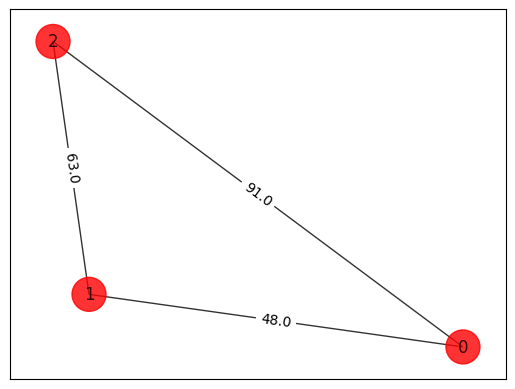

In [24]:
# Generating a graph of n nodes
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

## Brute Force Approach

In [25]:
# from itertools import permutations


# def brute_force_tsp(w, N):
#     a = list(permutations(range(1, N)))
#     last_best_distance = 1e10
#     for i in a:
#         distance = 0
#         pre_j = 0
#         for j in i:
#             distance = distance + w[j, pre_j]
#             pre_j = j
#         distance = distance + w[pre_j, 0]
#         order = (0,) + i
#         if distance < last_best_distance:
#             best_order = order
#             last_best_distance = distance
#             print("order = " + str(order) + " Distance = " + str(distance))
#     return last_best_distance, best_order


# best_distance, best_order = brute_force_tsp(adj_matrix, n)
# print(
#     "Best order from brute force = "
#     + str(best_order)
#     + " with total distance = "
#     + str(best_distance)
# )


# def draw_tsp_solution(G, order, colors, pos):
#     G2 = nx.DiGraph()
#     G2.add_nodes_from(G)
#     n = len(order)
#     for i in range(n):
#         j = (i + 1) % n
#         G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
#     default_axes = plt.axes(frameon=True)
#     nx.draw_networkx(
#         G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
#     )
#     edge_labels = nx.get_edge_attributes(G2, "weight")
#     nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


# draw_tsp_solution(tsp.graph, best_order, colors, pos)

## Mapping it to an Ising Problem

In [26]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [27]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 7581.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[-1282.5 +0.j, -1282.5 +0.j, -1282.5 +0.j, -1268.5 +0.j, -1268.5 +0.j,
 -1268.5 +0.j, -1290.  +0.j, -1290.  +0.j, -1290.  +0.j,   606.5 +0.j,
   606.5 +0.j,   606.5 +0.j,    12.  +0.j,    12.  +0.j,   606.5 +0.j,
    22.75+0.j,    22.75+0.j,   606.5 +0.j,    12.  +0.j,   606.5 +0.j,
    12.  +0.j,    22.75+0.j,   606.5 +0.j,    22.75+0.j,    

## Running on actual Quantum Device

In [28]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Options, Session

In [29]:
JESS_Token = "03ed20e2ac722b01fec7ed9cdda2c78416f74c6f760c6d0e5d287f804e771418d02d66f40d0be6d1256caf32ef23f5537fd9c0ccbb4046b120c787fbabdb11d5"

# loading the IBM Acoount with the Backend
QiskitRuntimeService.save_account(channel="ibm_quantum", token=JESS_Token,overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(operational=True, simulator=False)

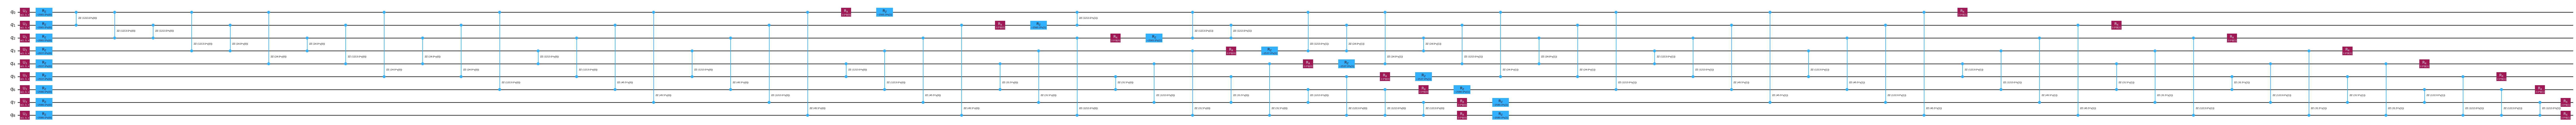

In [30]:
from qiskit.circuit.library import QAOAAnsatz
hamiltonian = qubitOp
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)
ansatz.decompose(reps=3).draw(output="mpl", style="iqp",fold=-1)

In [31]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
ansatz_isa = pm.run(ansatz)

In [33]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp",fold=-1)

ValueError: Image size of 86394x785 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 86394.4x785.944 with 1 Axes>

In [18]:
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

In [19]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

In [20]:
session = Session(backend=backend)
# Configure estimator
estimator = Estimator(session=session)
estimator.options.default_shots = 1000
# Configure sampler
sampler = Sampler(session=session)
sampler.options.default_shots = 1000


In [21]:
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

In [22]:
from scipy.optimize import minimize
res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")

IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [ ]:
res

In [ ]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
qc_isa = pm.run(qc)
qc_isa.draw(output="mpl", idle_wires=False, style="iqp",fold=-1)

In [ ]:
result = sampler.run([qc_isa]).result()

In [ ]:
print(result)

In [ ]:
samp_dist = result.quasi_dists[0]

In [ ]:
my_dict = dict(sorted(samp_dist.binary_probabilities().items(),key=lambda item: item[1], reverse=True))


In [ ]:
arrays = []

# Iterate over the keys of the dictionary
for key in my_dict.keys():
    # Convert the key to a numpy array of integers and append it to the list
    arrays.append(np.array([int(bit) for bit in key]))

# Convert the list of arrays to a numpy array
result = np.array(arrays)

print(result)

In [ ]:
x = result[0]

In [ ]:
print("feasible:", qubo.is_feasible(x))

In [ ]:
z = tsp.interpret(x)
print("solution:", z)

In [ ]:
from qiskit.visualization import plot_distribution
plot_distribution(samp_dist, figsize=(150, 5))